In [14]:
import sensors
import json
import ctypes
import csmapi

import pyproj 
import csmapi

from shapely.geometry import Polygon 
import numpy as np

dir(sensors)

['CartesianPoint',
 'CartesianPoint_swigregister',
 'ImagePoint',
 'ImagePoint_swigregister',
 'Sensor',
 'SensorModel',
 'SensorModelFactory',
 'SensorModelFactory_create',
 'SensorModelFactory_swigregister',
 'SensorModel_swigregister',
 'Sensor_swigregister',
 'ShapeModel',
 'ShapeModel_swigregister',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sensors',
 'sensors']

In [15]:
import os
lib = ctypes.CDLL(os.path.join(os.environ['CONDA_PREFIX'], 'lib/libusgscsm.dylib'))

In [16]:
isdfile = "/Users/krodriguez-pr/repos/SensorUtils/tests/data/simpleFramerISD.json"
isd = json.load(open(isdfile))

shape = {
    "semiminor" : 10,
    "semimajor": 10
}

sensor = sensors.Sensor(isdfile, '{"semiminor": 10, "semimajor": 10}')

In [17]:
# compute some things, but who knows if it's correct 
imgpt = sensors.ImagePoint(10.0,10.0,0.0)
grndpoint = sensor.imageToGround(imgpt)
grndpoint.x, grndpoint.y, grndpoint.z

(7.121065303152477, -4.964394673484238, -4.964394673484238)

In [18]:
sensor.phaseAngle(sensors.ImagePoint(10.0,100.0,0.0))

0.0

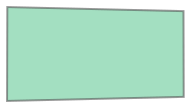

In [19]:
isd["image_lines"] = 15
isd["image_samples"] = 15

def footprint(camera, isd):
    def rect_to_lat(x, y, z, radius=3396190):
        ecef = pyproj.Proj(proj='geocent', a=radius, b=radius)
        lla = pyproj.Proj(proj='longlat', a=radius, b=radius)
        return pyproj.transform(ecef, lla, x, y, z)

    nlines = isd["image_lines"] 
    nsamples = isd["image_samples"]
    
    corner_pixels = [sensors.ImagePoint(0,0,1),
                     sensors.ImagePoint(0, nsamples-1,1),
                     sensors.ImagePoint(nlines-1, nsamples-1,1),
                     sensors.ImagePoint(nlines-1, 0,1)]
    
    ground_list = []
    for pixel in corner_pixels:
        ground = camera.imageToGround(pixel)
        lat, lon, alt = rect_to_lat(ground.x, ground.y, ground.z)
        ground_list.append([lat, lon, alt])
    ground_corners = np.asarray(ground_list)
    footprint = Polygon(ground_corners[:,[0,1]])
    return footprint
    
poly = footprint(sensor, isd)
poly